In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tskit as tsk
 
from bgspy.models import BGSModel
from bgspy.genome import Genome
from bgspy.utils import bin_chrom
from bgspy.data import GenomeData, pi_from_pairwise_summaries, trimmed_bins
from bgspy.sim_utils import mutate_simulated_tree
from bgspy.likelihood import FreeMutationModel
#from bgspy.sim_utils

2022-08-29 12:13:52.295448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [30]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [3]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
#g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
#g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

In [68]:
file = '../data/chrombgs_chr10_thresh0_N1000_mu3.16e-09_sh0.0316_chr10_seed1519291738_rep1_treeseq.tree'
file1 = '../data/chrombgs_chr10_thresh0_N10k_N10000_mu1e-08_sh0.01_chr10_seed3290190163_rep70_treeseq.tree'
file2 = '../data/chrombgs_chr10_thresh0_N10k_N10000_mu1e-08_sh0.01_chr10_seed3686382922_rep69_treeseq.tree'
ts = tsk.load(file2)

In [93]:
set([t.num_roots for t in ts.trees()])

{1}

In [70]:
import msprime as msp

#msp.sim_ancestry(ts, population_size=10000, recombination_rate=1e-8, initial_state=ts)

In [71]:
pkl_b_file= '../data/bmaps/bgspy/bmap_hg38_sims_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)

In [81]:
gd = GenomeData(g)
gd.load_neutral_masks('../data/annotation/neutral_phastcons_thresh0_slop1k_chr10.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [82]:
gd.load_counts_from_ts(mutate_simulated_tree(ts, rate=1e-7), chrom='chr10')

Load real genomic data for comparison (e.g. to see how sims compare).

In [117]:
hg38_gd = GenomeData(g)
hg38_gd.load_counts_dir('../data/h1kg/hg1k_counts/')
hg38_gd.load_neutral_masks('../data/annotation/neutral_phastcons_thresh0_slop1k_chr10.bed.gz')
hg38_gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [124]:
hg38_bins, hg38_pi = hg38_gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

In [212]:
winsize = 1_000_000

_, pi = gd.bin_pi(winsize)
bins, Y = gd.bin_reduce(winsize, merge=True)
trim_bins, trim_Y, trim_idx = trimmed_bins(Y, bins, (0.0, 0.99))

In [213]:
Bo = np.concatenate([m.BScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)
Bpo = np.concatenate([m.BpScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)

B, Bp = Bo[trim_idx, :], Bpo[trim_idx, :]

(array([  59.51555991,    0.        ,    0.        ,    0.        ,
          59.51555991,    0.        ,   59.51555991,  297.57779954,
         178.54667972,  416.60891935,  654.67115898,  416.60891935,
         714.18671889, 1249.82675805, 1487.88899768,  773.7022788 ,
         654.67115898,  416.60891935,  238.06223963,  119.03111981]),
 array([0.0016695 , 0.00179776, 0.00192602, 0.00205429, 0.00218255,
        0.00231081, 0.00243907, 0.00256734, 0.0026956 , 0.00282386,
        0.00295212, 0.00308038, 0.00320865, 0.00333691, 0.00346517,
        0.00359343, 0.00372169, 0.00384996, 0.00397822, 0.00410648,
        0.00423474]),
 <BarContainer object of 20 artists>)

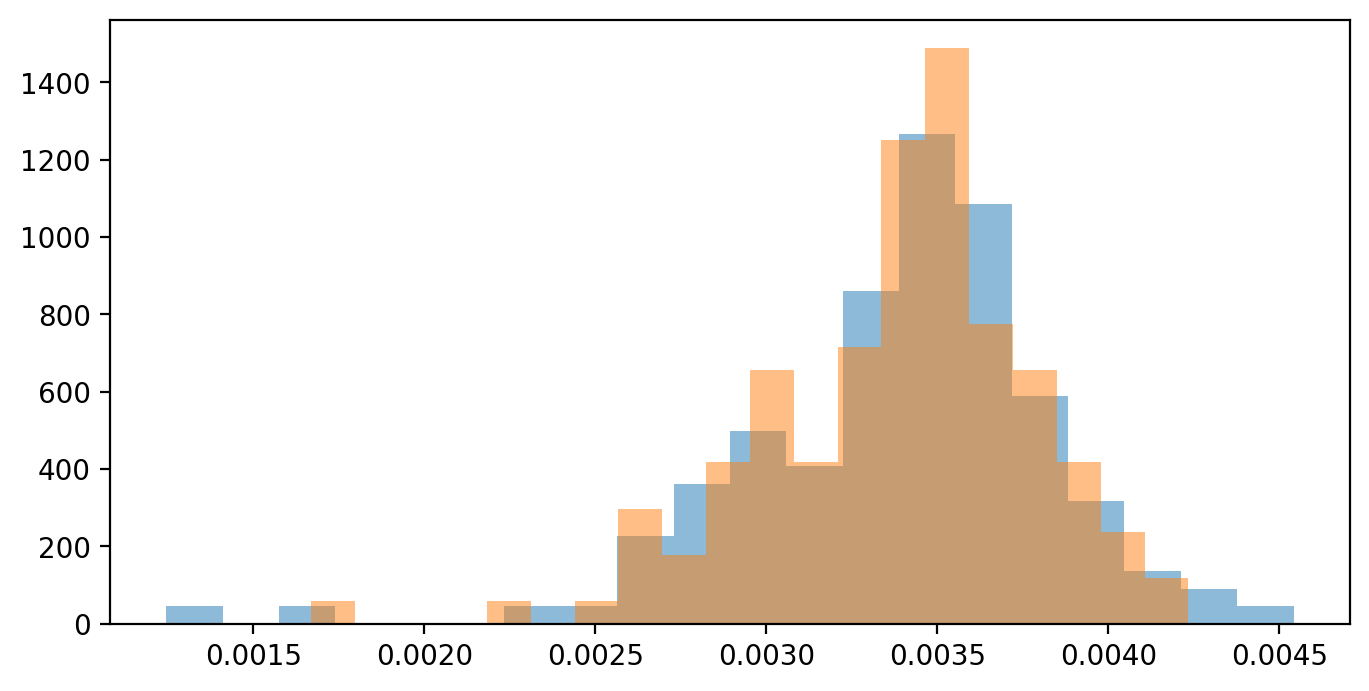

In [214]:
plt.hist(pi['chr10'].stat, 20, density=True, alpha=0.5)
plt.hist(pi_from_pairwise_summaries(trim_Y), 20, density=True, alpha=0.5)

In [215]:
ts_bins = bin_chrom(ts.sequence_length, winsize)
bm_pi = ts.diversity(mode='branch', windows=ts_bins)
ts_midpoints = (ts_bins[1:]+ts_bins[:-1])/2

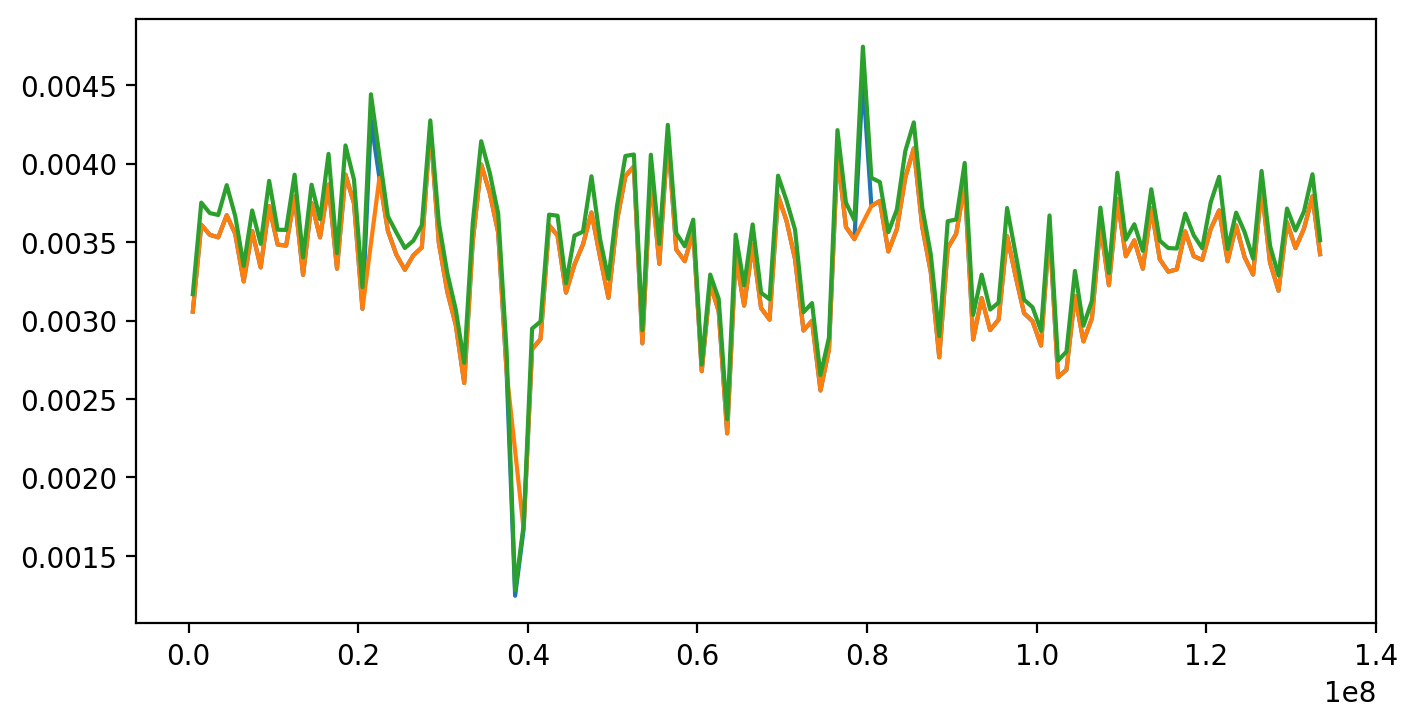

In [216]:
plt.plot(*pi['chr10'].pairs)

midpoints = [(s+e)/2 for c, s, e in trim_bins]
plt.plot(midpoints, pi_from_pairwise_summaries(trim_Y))

plt.plot(ts_midpoints, bm_pi * 1e-7)

In [217]:
m.t

array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
       0.1     ])

In [218]:
#np.random.seed(1)

#w, t = m.w, m.t
w = m.w
t = np.logspace(-4, -1, 4)
lik_nml = FreeMutationModel(w, t, Bp[:, :, [0, 2, 4, 6], :], Y=trim_Y)
lik_nml.fit(starts=10000, ncores=70, algo='NELDERMEAD')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1662.54it/s]


In [219]:
lik_nml

MLE (interpolated w): 6 x 4 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001 0.001  0.01   0.1   ]

Free-mutation model ML estimates:
negative log-likelihood: 592393689535069.6
π0 = 0.003662197447430079
W = 
----------
0.868975
0.0897395
0.0385272
0.00275842
----------
μ = 
-----------
3.63647e-08
-----------

In [220]:
lik_nml.theta_

array([3.66219745e-03, 3.16000000e-08, 3.26335067e-09, 1.40102903e-09,
       1.00309140e-10])

Text(0.5, 1.0, '$R^2 = 0.57$')

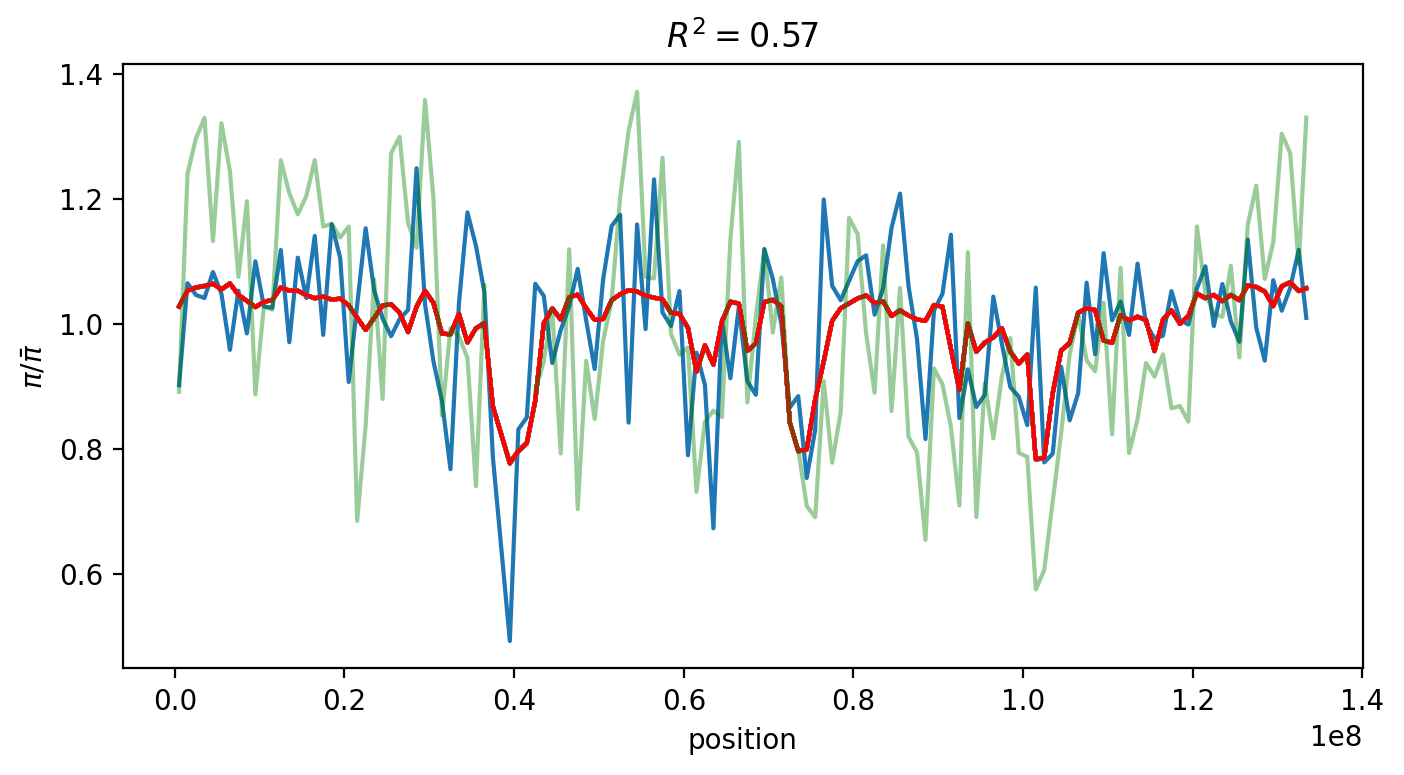

In [227]:
def ratio(x):
    return x/np.nanmean(x)


#plt.plot(ratio(pi['chr10'].pairs[1]))

midpoints = [(s+e)/2 for c, s, e in trim_bins]
#plt.scatter(midpoints, ratio(pi_from_pairwise_summaries(trim_Y)), s=5)
plt.plot(midpoints, ratio(pi_from_pairwise_summaries(trim_Y)))


for i in range(100):
    plt.plot(midpoints, ratio(lik_nml.predict(optim=i)), c='0.44', alpha=0.1)
    
plt.plot(midpoints, ratio(lik_nml.predict()), c='r')

hg38_x, hg38_y = hg38_pi['chr10'].pairs
plt.plot(hg38_x, ratio(hg38_y), c='g', alpha=0.4)
plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {lik_nml.R2():.2}$")

In [231]:
a = pi_from_pairwise_summaries(trim_Y) 
from bgspy.likelihood import R2
R2(np.repeat(lik_nml.predict().mean(), a.size), a)

-4.618771522579931e-16

In [222]:
lik_nml.R2()

0.5683285618057528

In [223]:
lik_nml

MLE (interpolated w): 6 x 4 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001 0.001  0.01   0.1   ]

Free-mutation model ML estimates:
negative log-likelihood: 592393689535069.6
π0 = 0.003662197447430079
W = 
----------
0.868975
0.0897395
0.0385272
0.00275842
----------
μ = 
-----------
3.63647e-08
-----------

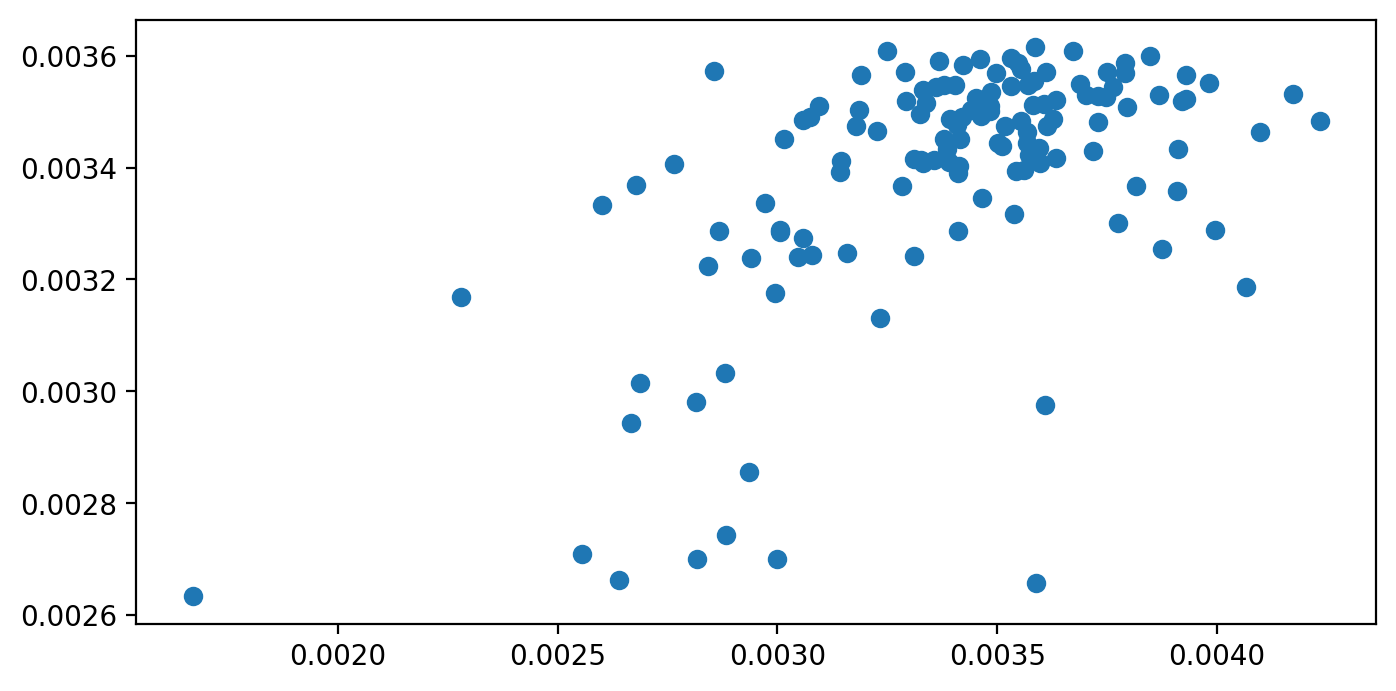

In [224]:
plt.scatter(pi_from_pairwise_summaries(trim_Y), lik_nml.predict())